## COVID Early Warning System Project Overview

Project goals, tools and techniques used, and data source info can be found [here](https://github.com/salvir1/covid-early-warning-system)

In [7]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Load in the COVID Tracking Project dataset by date and by state for US
covidtracking = pd.read_csv("https://api.covidtracking.com/v1/states/daily.csv")
df_state = covidtracking[['date', 'state', 'fips','positiveIncrease', 'deathIncrease', 'negativeIncrease']]
df_state['date'] = pd.to_datetime(df_state['date'], format='%Y%m%d')
df_state = df_state[df_state['date'] >= '2020-03-10']

st_population = pd.read_csv('../data/state_abbrev.csv', thousands=',') # Load in state population counts and merge with ctp data
df_state = df_state.merge(st_population, how='inner' ,left_on='state', right_on='Code')

# Normalize the daily counts by population
df_state['raw_case_rate'] = df_state['positiveIncrease'] / df_state['Population'] * 100000
df_state['negativeIncrease'] = df_state['negativeIncrease'] / df_state['Population'] * 100000
df_state['raw_death_rate'] = df_state['deathIncrease'] / df_state['Population'] * 100000

In [24]:
def case_rate_with_new_infections(ax, ST_cvd, chart_state, tick_spacing=31, scale=2.5, shift=-6, axvline_date=None):
    '''Creates a chart of raw cases as bars, 14-day MA, and estimated new infections
    Parameters
    ----------
    ax: matplotlib axis object
    ST_cvd: covid dataframe for given state
    chart_state: state name
    tick_spacing: int
    scale: rate of new infections as compared to actual diagnoses
    shift: number of days from new infection to average diagnosis recorded in data
    axvline_date: list of date ('yyyy-mm-dd'), 'comment']
    Returns
    -------
    axis object
    '''
    ST_cvd['date'] = pd.to_datetime(ST_cvd['date'], format='%Y%m%d')
    ST_cvd = ST_cvd.sort_values('date', ascending=True)
    ST_cvd['case_SMA_14'] = ST_cvd['raw_case_rate'].rolling(window=14).mean() 

    ax.bar(ST_cvd['date'], ST_cvd['raw_case_rate'], label="Cases (diagnoses)", alpha = 0.3, color='darkblue')
    ax.plot(ST_cvd['date'], 2.5 * ST_cvd['case_SMA_14'].shift(infection_shift), label="Estimated infections", color='green')
    ax.plot(ST_cvd['date'], ST_cvd['case_SMA_14'], label="Cases 14-day moving average", color='darkblue')
    ax.set_xlim([datetime.date(2020, 7, 1), datetime.date.today()])
    if axvline_date:
        ax.axvline(x=ST_cvd[ST_cvd['date']==axvline_date[0]]['date'], ls= '--', lw=1, color = 'black', label=axvline_date[1], alpha=0.75)
    ax.set_ylim(0)
    ax.set_title(f"Estimated infections and cases per 100,000 people for {chart_state}")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_ylabel('Case Rate')
    ax.legend()
    return ax

In [25]:
def case_rate_raw_and_smoothed(ax, ST_cvd, chart_state, tick_spacing=31):
    '''Creates a chart of raw cases as bars and 14-day MA
    Parameters
    ----------
    ax: matplotlib axis object
    ST_cvd: covid dataframe for given state
    chart_state: state name
    tick_spacing: int
    Returns
    -------
    axis object
    '''
    ST_cvd['date'] = pd.to_datetime(ST_cvd['date'], format='%Y%m%d')
    ST_cvd = ST_cvd.sort_values('date', ascending=True)
    ST_cvd['case_SMA_14'] = ST_cvd['raw_case_rate'].rolling(window=14).mean() 

    ax.bar(ST_cvd['date'], ST_cvd['raw_case_rate'], label="Cases (diagnoses)", color='darkblue', alpha = 0.3)
    ax.plot(ST_cvd['date'], ST_cvd['case_SMA_14'], label="Cases 14-day moving average", color='darkblue', )
    ax.set_xlim([datetime.date(2020, 7, 1), datetime.date.today()])
    ax.set_ylim(0)
    ax.set_title(f"Cases per 100,000 people for {chart_state}")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_ylabel('Case Rate')
    ax.legend()
    return ax

In [26]:
def case_rate_cv_trend(ax, ST_cvd, chart_state, tick_spacing=31):
    '''Creates a chart of the case rate coefficient of variation trend using prior 45 days
    Parameters
    ----------
    ax: matplotlib axis object
    ST_cvd: covid dataframe for given state
    chart_state: state name
    tick_spacing: int
    Returns
    -------
    axis object
    '''
    ST_cvd['date'] = pd.to_datetime(ST_cvd['date'], format='%Y%m%d')
    ST_cvd = ST_cvd.sort_values('date', ascending=True)
    ST_cvd = ST_cvd[ST_cvd['date'] >= '2020-06-15']
    cv_trend = [ST_cvd['raw_case_rate'].sort_index()[i:45+i].std() / ST_cvd['raw_case_rate'].sort_index()[i:45+i].mean() for i in range(len(ST_cvd['raw_case_rate'])-45)][::-1]
    ax.plot(ST_cvd['date'].sort_values()[45:], cv_trend, label ='CV using prior 45 days ', color='darkblue')
    ax.set_ylim(0)
    ax.set_title(f"Case rate coefficient of variation for {chart_state}")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_ylabel('Case Rate Coeff Var')
    ax.legend()
    return ax

In [27]:
def positivity_raw_and_smoothed(ax, ST_cvd, chart_state, tick_spacing=31):
    '''Creates a chart of daily positive test rate, raw and smoothed
    Parameters
    ----------
    ax: matplotlib axis object
    ST_cvd: covid dataframe for given state
    chart_state: state name
    tick_spacing: int
    Returns
    -------
    axis object
    '''
    ST_cvd['date'] = pd.to_datetime(ST_cvd['date'], format='%Y%m%d')
    ST_cvd = ST_cvd.sort_values('date', ascending=True)
    ST_cvd['positivity'] = ST_cvd['raw_case_rate'] / (ST_cvd['raw_case_rate']  + ST_cvd['negativeIncrease'] ) * 100
    ST_cvd['positivity'] = np.where(ST_cvd['positivity']>=90, ST_cvd['positivity'].mean(), ST_cvd['positivity'])
    ST_cvd['positivity_SMA'] = ST_cvd['positivity'].rolling(window=14).mean()

    ax.bar(ST_cvd['date'], ST_cvd['positivity'], label="Cases (diagnoses)", alpha = 0.3, color='green')
    ax.plot(ST_cvd['date'], ST_cvd['positivity_SMA'], label="Cases 14-day moving average", color='green')
    ax.set_xlim([datetime.date(2020, 7, 1), datetime.date.today()])
    ax.set_ylim(0)
    ax.set_title(f"Positive test rate by day for {chart_state}")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_ylabel('Positive Test Rate')
    ax.legend()
    return ax

In [28]:
def positiivity_cv_trend(ax, ST_cvd, chart_state, tick_spacing=31):
    '''Creates a chart of the positive test rate coefficient of variation trend using prior 45 days
    Parameters
    ----------
    ax: matplotlib axis object
    ST_cvd: covid dataframe for given state
    chart_state: state name
    tick_spacing: int
    Returns
    -------
    axis object
    '''
    ST_cvd['date'] = pd.to_datetime(ST_cvd['date'], format='%Y%m%d')
    ST_cvd = ST_cvd.sort_values('date', ascending=True)
    ST_cvd = ST_cvd[ST_cvd['date'] >= '2020-06-15']
    ST_cvd['positivity'] = ST_cvd['raw_case_rate'] / (ST_cvd['raw_case_rate']  + ST_cvd['negativeIncrease'] ) * 100
    ST_cvd['positivity'] = np.where(ST_cvd['positivity']>=90, ST_cvd['positivity'].mean(), ST_cvd['positivity'])
    cv_trend = [ST_cvd['positivity'].sort_index()[i:45+i].std() / ST_cvd['positivity'].sort_index()[i:45+i].mean() for i in range(len(ST_cvd['positivity'])-45)][::-1] 
    ax.plot(ST_cvd['date'].sort_values()[45:], cv_trend, label ='CV using prior 45 days ', color='green')
    ax.set_ylim(0)
    ax.set_title(f"Positive test rate coefficient of variation trend for {chart_state}")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_ylabel('Positive Test Rate Coeff Var')
    ax.legend()
    return ax

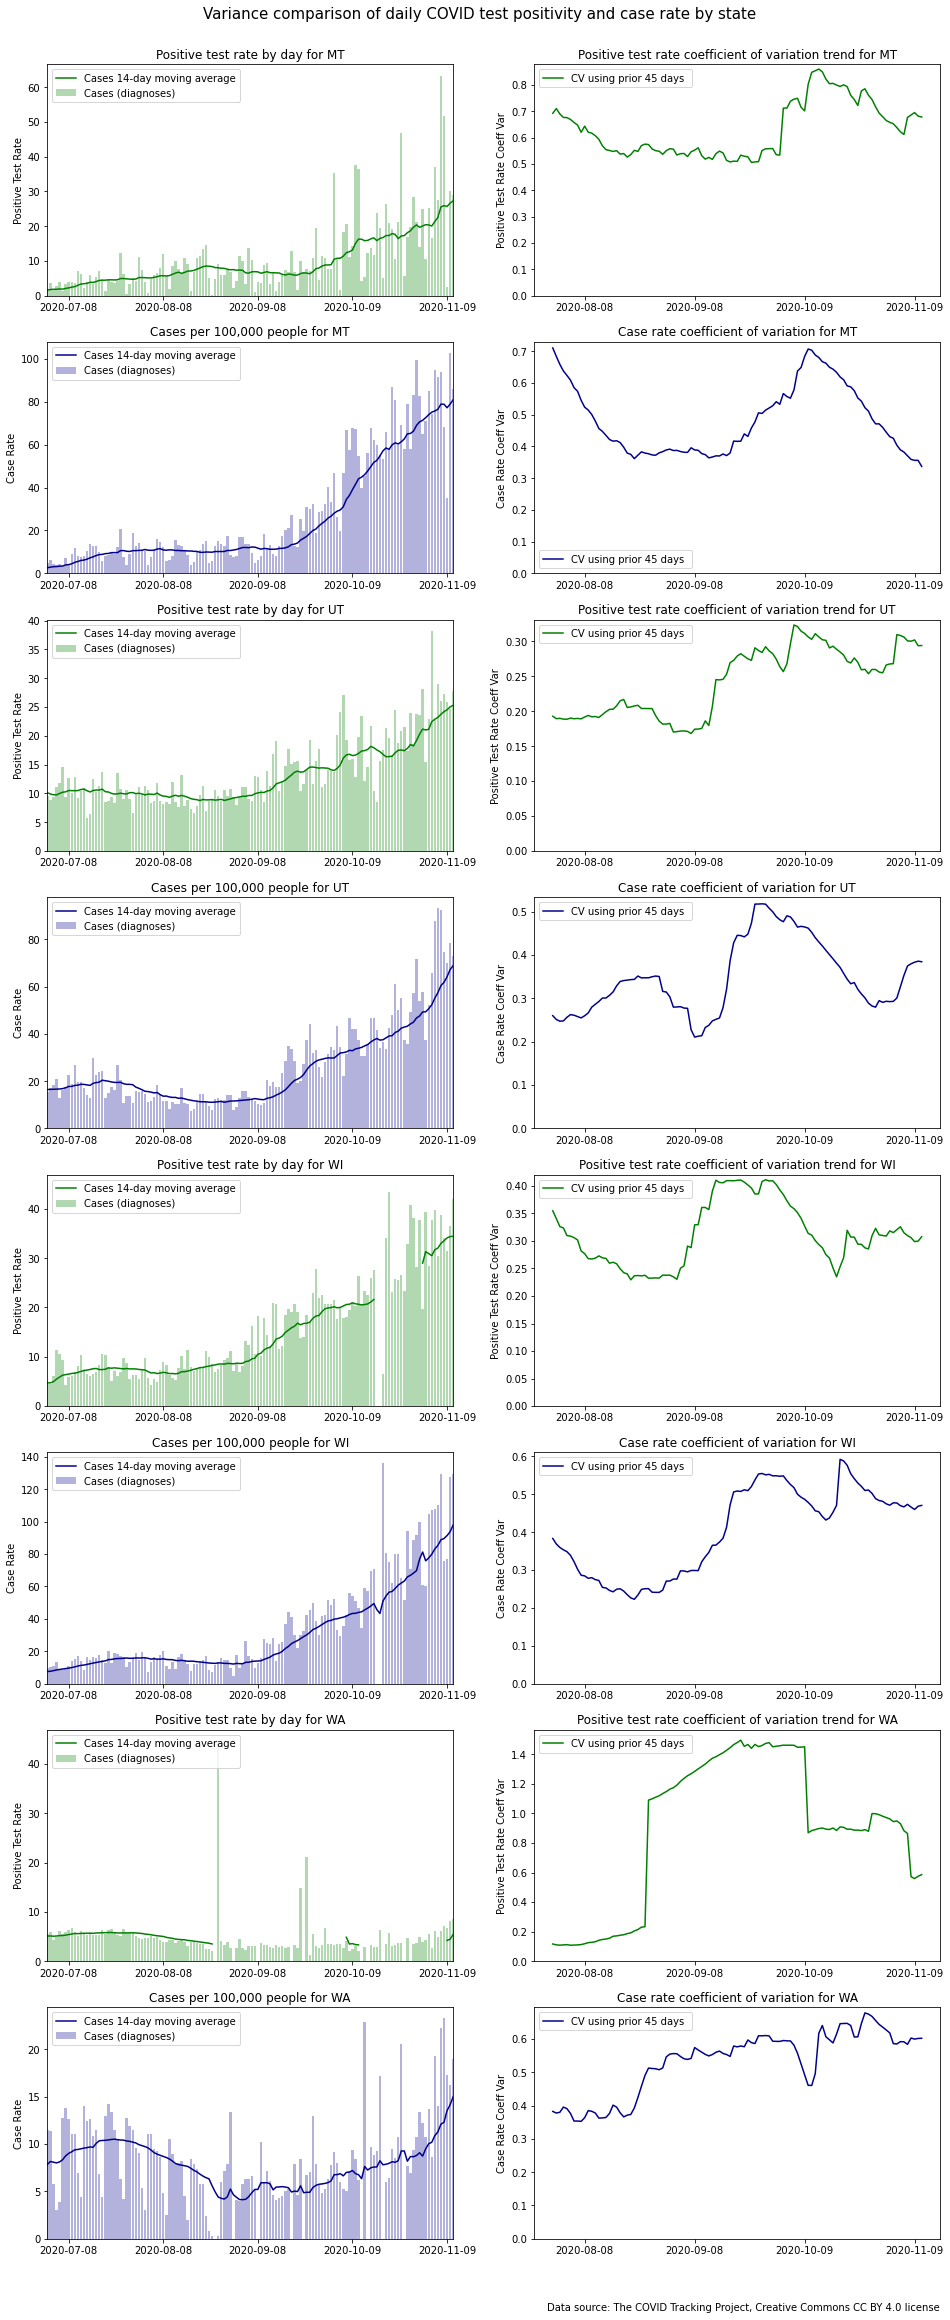

In [22]:
# Chart set: Variance comparisons for positive test rate and case rate 

# define macro variables
tick_spacing = 31 # Display one tick per month
# states_list = ['MT', 'UT', 'WI', 'WA', 'AR', 'MO']
states_list = ['MT', 'UT', 'WI', 'WA']
figs = len(states_list) * 4

fig,axs = plt.subplots(int(figs/2),2,figsize=(16,(5 * figs / 2)))
fig.suptitle(f'Variance comparison of daily COVID test positivity and case rate by state', size=15, y = 0.9)
plt.figtext(0.9, 0.1,
            'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
for i in range(len(states_list)):
    ST_df = df_state[df_state['state'] == states_list[i]]
    positivity_raw_and_smoothed(axs[i*2][0], ST_df, states_list[i], tick_spacing)
    positiivity_cv_trend(axs[i*2][1], ST_df, states_list[i], tick_spacing)
    case_rate_raw_and_smoothed(axs[i*2+1][0], ST_df, states_list[i], tick_spacing)
    case_rate_cv_trend(axs[i*2+1][1], ST_df, states_list[i], tick_spacing)
plt.savefig('img/coefficient-of-variation-analysis.png')

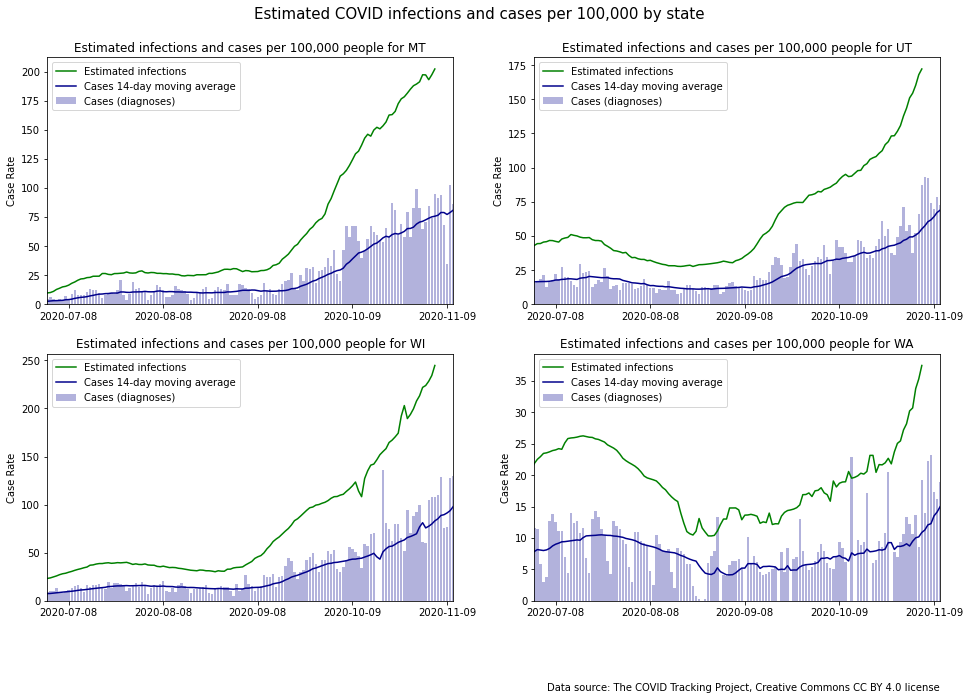

In [23]:
# Chart set: Estimated infections and diagnoses

# define macro variables
infection_shift = -6 # Number of days new active infection appears before positive case enters database (negative)
tick_spacing = 31 # Display one tick per month
scale = 2.5
# states_list = ['MT', 'UT', 'WI', 'WA', 'AR', 'MO']
states_list = ['MT', 'UT', 'WI', 'WA']
figs = len(states_list)

fig,axs = plt.subplots(((figs-1)//2 + 1),2,figsize=(16,(5 * ((figs-1)//2 + 1))))
fig.suptitle(f'Estimated COVID infections and cases per 100,000 by state', size=15, y=0.95)
plt.figtext(0.9, 0, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
for i, ax in enumerate(axs.flatten()):
    if i < len(states_list):
        ST_df = df_state[df_state['state'] == states_list[i]]
        case_rate_with_new_infections(ax, ST_df, states_list[i], tick_spacing, scale, infection_shift)
plt.savefig('img/case-rate-and-est-infections.png')

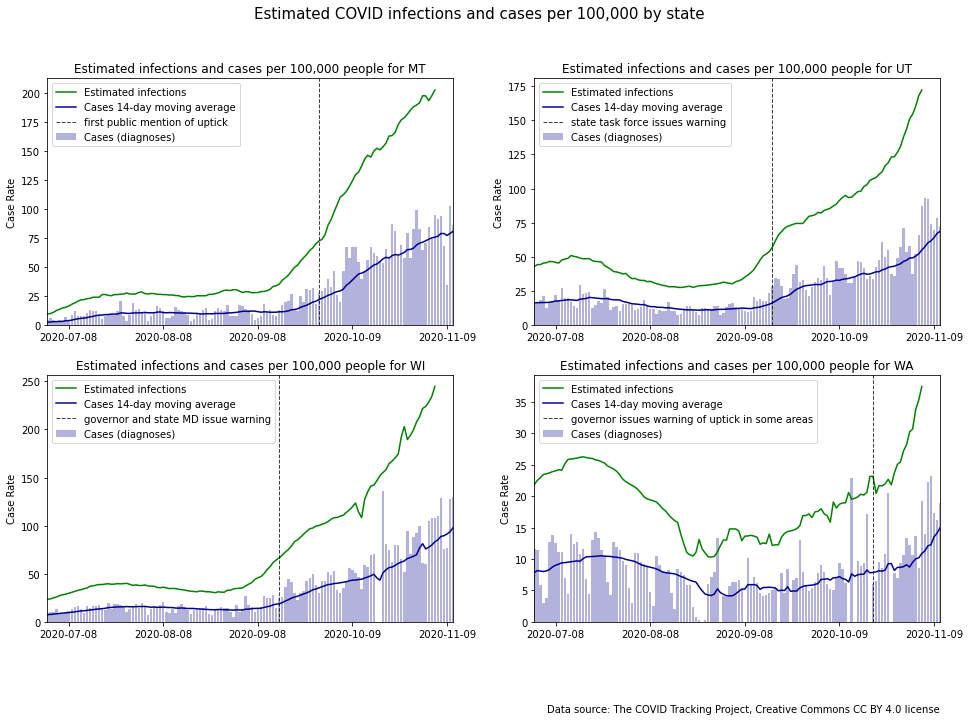

In [48]:
# Chart set: Estimated infections and diagnoses with state recognition of emerging outbreak

# define macro variables
infection_shift = -6 # Number of days new active infection appears before positive case enters database (negative)
tick_spacing = 31 # Display one tick per month
scale = 2.5
states_list = ['MT', 'UT', 'WI', 'WA']
figs = len(states_list)
recognition_dict = {
                    'MT': ['2020-09-28', 'first public mention of uptick'],
                    'UT': ['2020-09-17', 'state task force issues warning'],
                    'WI': ['2020-09-15', 'governor and state MD issue warning'],
                    'WA': ['2020-10-20', 'governor issues warning of uptick in some areas'],
                    }

fig,axs = plt.subplots(((figs-1)//2 + 1),2,figsize=(16,(5 * ((figs-1)//2 + 1))))
fig.suptitle(f'Estimated COVID infections and cases per 100,000 by state', size=15) # , y=0.95
plt.figtext(0.9, 0, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
for i, ax in enumerate(axs.flatten()):
    if i < len(states_list):
        ST_df = df_state[df_state['state'] == states_list[i]]
        case_rate_with_new_infections(ax, ST_df, states_list[i], tick_spacing, scale, infection_shift, axvline_date=recognition_dict[states_list[i]])
plt.savefig('img/COVID-infections-and-cases-with-response.png')

### State-level case and death rate animations by week

In [ ]:
st_population = pd.read_csv('../data/state_abbrev.csv', thousands=',') # Load in state population counts and merge with ctp data
df_state = df_state.merge(st_population, how='inner' ,left_on='state', right_on='Code')
df_state.isna().sum() # No missing values!
df_state['CVD_group'] = df_state['CVD_group'].apply(lambda x: 'No outbreak' if x == 0 else x)
df_state['CVD_group'] = df_state['CVD_group'].apply(lambda x: 'Spring outbreak' if x == 1 else x)
df_state['CVD_group'] = df_state['CVD_group'].apply(lambda x: 'Summer outbreak' if x == 2 else x)
df_state['CVD_group'] = df_state['CVD_group'].apply(lambda x: 'Fall outbreak' if x == 3 else x)

In [ ]:
# Prepare data table for the animation of deaths per 100,000 and cases per 100,000 by state.
# Group data by week for the animation, but convert it into a daily statistic for consistency with other charts

In [ ]:
# Close out on a complete week (ending Sunday) when reporting weekly statistics.
today = datetime.date.today()
last_monday = pd.to_datetime(today + datetime.timedelta(days=-today.weekday(), weeks=0))
df_state = df_state[df_state['date'] < last_monday]
df_state = df_state.sort_values('date', ascending=True)

In [ ]:
# Start by grouping by state and week. (Summing over the week speeds up the animation.)
df_state['week']=df_state['date'].dt.week
df_state_by_week = df_state.groupby(['week','state','Population']).agg(
                                    deaths = ('deathIncrease', 'sum'),
                                    cases = ('positiveIncrease','sum'),
                                    negatives = ('negativeIncrease','sum'),
                                    Date = ('date', 'max')).reset_index()

In [ ]:
# Slight smoothing of death rate (2 weeks or 14 days total) to match the smoothing used in the groupings charts
death_SMA = []
for chart_state in df_state_by_week['state'].unique():
    state = df_state_by_week[df_state_by_week['state']== chart_state]
    death_SMA.append(state.iloc[:,3].rolling(window=2).mean())
df_state_by_week['death_SMA']= pd.concat(death_SMA)

In [ ]:
# Calculate weekly stats for the animations
df_state_by_week['deaths_per_100000'] = df_state_by_week['death_SMA'] / 7
df_state_by_week['cases_per_100000'] = df_state_by_week['cases']  / 7
df_state_by_week['positive_test_rate'] = df_state_by_week['cases'] / (df_state_by_week['cases'] + df_state_by_week['negatives'])

In [ ]:
df_state_by_week['timestamp'] = df_state_by_week['Date'].apply(lambda x: x.date()).apply(str) # convert timestamp to a string 
df_state_by_week = df_state_by_week.sort_values('timestamp', ascending=True)

In [ ]:
fig = px.choropleth(df_state_by_week,                   # Input Dataframe
                     locations="state",                 # state abbrev column
                     locationmode="USA-states",         # use plotly-supplied state geometries
                     color="cases_per_100000",          # feature column
                     hover_name="state",                # hover name
                     animation_frame="timestamp",       # date column
                     scope="usa",
                     color_continuous_scale = 'Viridis_r',  
                     range_color=[0,300/7],             # select range of dataset
                     labels={'cases_per_100000':'Cases per 100,000'},
                     title='Daily COVID cases per 100,000 residents'     
                     )                 
fig.write_html("img/case-rate-map.html", auto_open=True)                      

In [ ]:
fig = px.choropleth(df_state_by_week,                   # Input Dataframe
                     locations="state",                 # state abbrev column
                     locationmode="USA-states",         # use plotly-supplied state geometries
                     color="positive_test_rate",        # feature column
                     hover_name="state",                # hover name
                     animation_frame="timestamp",       # date column
                     scope="usa",
                     color_continuous_scale = 'Viridis_r',  
                     range_color=[0,0.4],             # select range of dataset
                     labels={'positive_test_rate':'Positive test rate'},
                     title='COVID positive test rate'     
                     )                 
fig.write_html("img/positive-rate-map.html", auto_open=True)                      

In [ ]:
fig = px.choropleth(df_state_by_week,                   # Input Dataframe
                     locations="state",                 # state abbrev column
                     locationmode="USA-states",         # use plotly-supplied state geometries
                     color="deaths_per_100000",         # feature column
                     hover_name="state",                # hover name
                     animation_frame="timestamp",       # date column
                     scope="usa",
                     color_continuous_scale = 'bluered',  
                     range_color=[0,5.5/7],             # select range of dataset
                     labels={'deaths_per_100000':'Deaths per 100,000'},
                     title='Daily COVID deaths per 100,000 residents'     
                     )        
fig.write_html("img/death-rate-map.html", auto_open=True)                      

### State level time series

In [ ]:
# Calculate simple moving averages. 

case_SMA = []
death_SMA = []
negatives_SMA = []

for chart_state in df_state['state'].unique():
    state = df_state[df_state['state']== chart_state]
    df_state_by_week.sort_values('timestamp', ascending=True)
    case_SMA.append(state.iloc[:,3].rolling(window=14).mean())
    death_SMA.append(state.iloc[:,4].rolling(window=14).mean())
    negatives_SMA.append(state.iloc[:,5].rolling(window=14).mean())
df_state['case_SMA']= pd.concat(case_SMA)
df_state['death_SMA']= pd.concat(death_SMA)
df_state['negatives_SMA']= pd.concat(negatives_SMA)
df_state['positive_test_rate'] = df_state['case_SMA'] / (df_state['case_SMA'] + df_state['negatives_SMA'])
df_state['case_SMA'] = df_state['case_SMA']
df_state['death_SMA'] = df_state['death_SMA']

In [ ]:
# Calculate the case_SMA change over 5, 10, 15 days to determine if rate of change correlates with groupings
case_SMA_5_day_change = []
case_SMA_10_day_change = []
case_SMA_15_day_change = []
for chart_state in df_state['state'].unique():
    state = df_state[df_state['state']== chart_state]
    case_SMA_5_day_change.append(state['case_SMA'] - state['case_SMA'].shift(5))
    case_SMA_10_day_change.append(state['case_SMA'] - state['case_SMA'].shift(10))
    case_SMA_15_day_change.append(state['case_SMA'] - state['case_SMA'].shift(15))
df_state['case_SMA_5_day_change']= pd.concat(case_SMA_5_day_change)
df_state['case_SMA_10_day_change']= pd.concat(case_SMA_10_day_change)
df_state['case_SMA_15_day_change']= pd.concat(case_SMA_15_day_change)


In [ ]:
first, last = (0, 25)

# Death rate by state over time--ungrouped
fig, ax = plt.subplots(figsize = (15,7))
    
for chart_state in df_state['state'].unique()[first:last]:
    state_df = df_state[df_state['state']== chart_state]
    ax.plot(state_df['date'], state_df['death_SMA'], label = chart_state)
    ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 31)])
    ax.set_ylim(0, 1)
    ax.set_title(f'COVID death rate per 100,000 for 25 states')
    ax.legend()
plt.savefig('img/COVID-deaths-by-state-large-group.png')

In [ ]:
# Deaths per 100,000 by state over time
fig, ax = plt.subplots(2,2, figsize = (18,14))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.suptitle(f'Daily COVID deaths per 100,000 by outbreak groupings (14-day simple moving average)', size=15, y=0.95)

i=0
for group in df_state['CVD_group'].unique():
    temp_df = df_state[df_state['CVD_group']==group]
    for chart_state in temp_df['state'].unique():
        state_df = temp_df[temp_df['state']== chart_state]
        ax[i//2][i%2].plot(state_df['date'], state_df['death_SMA'], label = chart_state)
    ax[i//2][i%2].axhline(y=0.8, ls= '--', lw=1, color = 'gray', alpha=0.25)
    ax[i//2][i%2].axhline(y=0.5, ls= '--', lw=1, color = 'gray')
    ax[i//2][i%2].set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
    ax[i//2][i%2].set_ylim([0,1.2])
    ax[i//2][i%2].set_title(f'{group} group')
    ax[i//2][i%2].legend()
    i += 1
plt.savefig('img/COVID-deaths-by-state.png')

In [ ]:
# Cases per 100,000 by state over time
fig, ax = plt.subplots(2,2, figsize = (18,14))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.suptitle(f'Daily COVID cases per 100,000 by outbreak groupings (14-day simple moving average)', size=15, y=0.95)

i=0
for group in df_state['CVD_group'].unique():
    temp_df = df_state[df_state['CVD_group']==group]
    for chart_state in temp_df['state'].unique():
        state_df = temp_df[temp_df['state']== chart_state]
        ax[i//2][i%2].plot(state_df['date'], state_df['case_SMA'], label = chart_state)
    ax[i//2][i%2].axhline(y=25, ls= '--', lw=1, color = 'gray')
    ax[i//2][i%2].set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
    ax[i//2][i%2].set_ylim([0,50])
    ax[i//2][i%2].set_title(f'{group} group')
    ax[i//2][i%2].legend()
    i += 1
plt.savefig('img/COVID-cases-by-state.png')

In [ ]:
# Positive test rate by state over time
fig, ax = plt.subplots(2,2, figsize = (18,14))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.suptitle(f'COVID positive test rate by outbreak groupings (14-day simple moving average)', size=15, y=0.95)

i=0
for group in df_state['CVD_group'].unique():
    temp_df = df_state[df_state['CVD_group']==group]
    for chart_state in temp_df['state'].unique():
        state_df = temp_df[temp_df['state']== chart_state]
        ax[i//2][i%2].plot(state_df['date'], state_df['positive_test_rate'], label = chart_state)
    ax[i//2][i%2].axhline(y=20, ls= '--', lw=1, color = 'gray')
    ax[i//2][i%2].set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
    ax[i//2][i%2].set_ylim([0,0.4])
    ax[i//2][i%2].set_title(f'{group} group')
    ax[i//2][i%2].legend()
    i += 1
plt.savefig('img/COVID-positive-test-rate-by-state.png')

In [ ]:
# Case rate change by state over time
fig, ax = plt.subplots(2,2, figsize = (18,14))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.suptitle(f'Change in daily COVID cases per 100,000 from 10 days prior, by outbreak groupings (14-day simple moving average)', size=15, y=0.95)

i=0
for group in df_state['CVD_group'].unique():
    temp_df = df_state[df_state['CVD_group']==group]
    for chart_state in temp_df['state'].unique():
        state_df = temp_df[temp_df['state']== chart_state]
        ax[i//2][i%2].plot(state_df['date'], state_df['case_SMA_10_day_change'], label = chart_state)
#     ax[i//2][i%2].axhline(y=20, ls= '--', lw=1, color = 'gray')
    ax[i//2][i%2].set_xlim([datetime.date(2020, 5, 1), datetime.date.today()])
    ax[i//2][i%2].set_ylim([-20,20])
    ax[i//2][i%2].set_title(f'{group} group')
    ax[i//2][i%2].legend()
    i += 1

### Misc charts

In [ ]:
chart_state = 'WA'
state_df = df_state[df_state['state']== chart_state]
state_df['case_SMA'] = state_df.iloc[:,3].rolling(window=14).mean()
state_df['death_SMA'] = state_df.iloc[:,4].rolling(window=14).mean()
temp_state_df = state_df[['date', 'death_SMA']]
temp_state_df['date'] = temp_state_df['date'] - timedelta(days=21)
state_df = state_df.merge(temp_state_df, on='date')

In [ ]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(state_df['date'], state_df['death_SMA_y'] / state_df['case_SMA'], label = 'case fatality ratio', color = 'purple', lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 15)])
ax.set_ylim(0, 0.1)
ax.set_title(f'{chart_state} COVID case fatality ratio (deaths were time-shifted to synchronize with initial diagnosis)')
ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(state_df['date'], state_df['death_SMA_x'], label = 'deaths', lw= .5)
ax.plot(state_df['date'], state_df['death_SMA_y'], label = 'deaths shifted', color = 'gray', lw=3)
ax.plot(state_df['date'], state_df['case_SMA'] / 70, label = 'cases / 70', color = 'orange', lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 15)])
ax.set_title(f'{chart_state} COVID cases and deaths (deaths time-shifted 21 days to synchronize with cases)')
ax.legend()

In [ ]:
# Case fatality ratio by state over time
fig, ax = plt.subplots(figsize = (15,7))
    
for chart_state in df_state['state'].unique()[first:last]:
    state_df = df_state[df_state['state']== chart_state]
    state_df['case_SMA'] = state_df.iloc[:,3].rolling(window=7).mean()
    state_df['death_SMA'] = state_df.iloc[:,4].rolling(window=7).mean()
    temp_state_df = state_df[['date', 'death_SMA']]
    temp_state_df['date'] = temp_state_df['date'] - timedelta(days=14)
    state_df = state_df.merge(temp_state_df, on='date')
    ax.plot(state_df['date'], state_df['death_SMA_y'] / state_df['case_SMA'], label = chart_state)
    ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 31)])
    ax.set_ylim(0, 0.1)
    ax.set_title(f'COVID case fatality ratio (deaths were time-shifted to synchronize with initial diagnosis)')
    ax.legend()

### COVID metrics may lead to delayed responses

COVID metrics generally rely on tracking the trend of positive diagnoses and the trend of the positive test rates (positive cases / total cases). It is implicit in today's COVID monitoring systems that most COVID cases are being diagnosed so the tracking statistics are highly representative of the spread of infection through the population (i.e. they don't rely on taking a sample of the population). This may be true, but that doesn't mean this approach is optimal. The current COVID monitoring systems experience two major delays that may hinder the timely identification of a regional outbreak (such as one at the state leve).

One source of delay is introduced because the COVID monitoring systems are monitoring mainly symptomatic people. Another source of delay comes from the noise introduced in the testing regimen. Both of these sources of delay will be discussed in turn.

#### Delay caused by monitoring mainly symptomatic people

This source of delay is easy to understand. People who become infected with COVID generally won't know to be tested (unless contact tracing is in place and working well) until they develop symptoms which is commonly thought to be 4-5 days on average. They then need to decide to get tested, get tested (probably depends on the severity of the infection--it could range from 1 day to never), and await for the test results find their way to the tracking system (for PCR tests can vary from 1 to several days). A simple estimate suggests this delay could easily 8 days or more from infection. Some research will be done tro try to pin down a more accurate measure.

#### Delay caused by noise introduced into the system through uncontrolled COVID testing regimens

COVID testing regimens have been designed for other reasons than to provide a statistically accurate measure of the changing rate of infection in a population. As such, noise finds its way into the signal. COVID metrics such as total cases per day, case rate, and positive test rate suffer from enough noise that they are generally reported with a moving average (7-day, 14-day, and occasionally 28-day) in order to see the underlying trend. The charts in this study all utilize a 14-day simple moving average (SMA). 

The source of much of this noise is the same for all metrics, although it doesn't affect all metrics equally. One source of noise comes from the COVID testing process. 

For instance, the COVID test sites in a jurisdiction often test for different reasons. Clinics may be doing pre-procedural testing to confirm the absence of COVID pre-procedure. Positive test rates from these sites will mirror disease prevalence among asymptomatic people, which is at most 1-2% and often lower. These clinics may perform these tests only a few days a week. Locations run by public health agencies may be testing mostly symptomatic people some days. Positive test rates from these sites on these days may exceed 25% or more. At different days for these same public health agency locations, they may test a high percentage of asymptomatic students from a school or employees from a company, thus reducing the positive test rate significantly.

States report all submitted test reports in a single batch for a day. A test site's contribution to the total can fluctuate significantly from day-to-day. Consequently, the ratio of symptomatic to asymptomatic people in a batched daily test report for a state can--and does--vary tremendously. Clearly this has a direct impact on the positive test rate metric. You can see the variability in the signal in the following positive test rate time series.

<img align="center" src="img/COVID-positive-test-rate-by-outbreak-groupings-showing-daily-variability.png" width='1000' height='auto' ></img>

Another layer of noise is introduced when test samples are processed at the labs and reported back. Test sites across a state may utilize different labs. Turnaround times for the various labs are often different. Some labs may batch tests and report several days worth of results at a time, where others report every 24 hours. Not only could this lack of process affect the ratio of symptomatic to asymptomatic people in a batched daily test report, it can have a big impact on the total number of tests reported on in any given day. Taken together, the fluctuating ratios of symptomatic to asymptomatic people in the test pool and the different batching methods contribute to noisiness in the signal from day-to-day. This shows up in COVID monitoring metrics such as the positive test rate (the previous chart) and the case rate time series below.

<img align="center" src="img/COVID-cases-by-outbreak-groupings-showing-daily-variability.png" width='1000' height='auto' ></img>

One final topic worth mentioning is how changes in testing availability has affected the signal over time. COVID testing has become more available and more cases of COVID are diagnosed today than over the summer or during the early months of the pandemic. We are capturing more symptomatic cases today than several months ago, and we will likely catch more in the future. An increase in total positive COVID tests for a day does not necessarily mean that the infection is spreading. Then again, it doesn't mean that it isn't spreading. That's the problem. The signal is noisy. 




The noisiness of all of these signals is a major impediment to early detection. Given the infectiousness of COVID, an uptick can quickly turn into an outbreak. It is already challenging for governments and public health agencies to keep COVID in check. The noise in these signals adds costly delay. More about this can be found in the discussion on COVID surveillance systems [here](https://github.com/salvir1/covid-early-warning-system).